In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from util import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
import torch_optimizer as optim
from sklearn.model_selection import StratifiedKFold

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
excluded_base_names = [
    "s-prd-462542531.jpg",
    "s-prd-567681349.jpg",
    "s-prd-595361939.jpg",
    "s-prd-719354460.jpg",
    "s-prd-752575241.jpg",
    "s-prd-470472240.jpg",
    "s-prd-601218250.jpg",
    "s-prd-632469223.jpg",
    "s-prd-653536778.jpg",
    "s-prd-767507626.jpg"
]

def load_and_split_cropped_dataset(cropped_dirs, metadata_csv):
    """
    Args:
        cropped_dirs (list): List of directories containing cropped images.
        metadata_csv (str): Path to metadata CSV.
    Returns:
        train_df, val_df, test_df: DataFrames split from matched metadata.
    """
    df = pd.read_csv(metadata_csv)

    # Filter out control images
    df = df[df['midas_iscontrol'].str.lower() == 'no']

    # Normalize fields
    df['midas_distance'] = df['midas_distance'].str.lower()

    # Define modality
    df['modality'] = df['midas_distance'].apply(
        lambda x: 'dermoscope' if x == 'dscope' else ('clinical' if isinstance(x, str) else None)
    )

    # Filter to only 6in clinical images
    df = df[(df['modality'] == 'clinical') & (df['midas_distance'] == '6in')]

    # Assign label based on midas_path
    df['label'] = df['midas_path'].str.lower().str.contains("malig").astype(int)

    # Prepare for matching
    df['base_name'] = df['midas_file_name'].apply(lambda x: os.path.splitext(x)[0])
    metadata_lookup = df.set_index('base_name')

    metadata_lookup = metadata_lookup.drop(excluded_base_names, errors='ignore')

    # Match across all cropped directories
    matched_rows = []
    for cropped_dir in cropped_dirs:
        for f in os.listdir(cropped_dir):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                base = os.path.splitext(f)[0]
                if base in metadata_lookup.index:
                    row = metadata_lookup.loc[base]
                    matched_rows.append({
                        'midas_record_id': row['midas_record_id'],
                        'clinical_path': os.path.join(cropped_dir, f),
                        'label': row['label'],
                        'clinical_midas_distance': row['midas_distance']
                    })

    matched_df = pd.DataFrame(matched_rows)

    # Split into train, val, test
    train_val, test_df = train_test_split(
        matched_df, test_size=0.15, random_state=42, stratify=matched_df["label"]
    )
    train_df, val_df = train_test_split(
        train_val, test_size=0.1765, random_state=42, stratify=train_val["label"]
    )

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

def generate_kfold_csv(
    cropped_dirs, 
    metadata_csv, 
    output_csv="kfold_midas.csv", 
    n_splits=5, 
    random_state=42, 
    test_size=0.15
):
    excluded_base_names = [
        "s-prd-462542531.jpg",
        "s-prd-567681349.jpg",
        "s-prd-595361939.jpg",
        "s-prd-719354460.jpg",
        "s-prd-752575241.jpg",
        "s-prd-470472240.jpg",
        "s-prd-601218250.jpg",
        "s-prd-632469223.jpg",
        "s-prd-653536778.jpg",
        "s-prd-767507626.jpg"
    ]

    df = pd.read_csv(metadata_csv)
    df = df[df['midas_iscontrol'].str.lower() == 'no']
    df['midas_distance'] = df['midas_distance'].str.lower()
    df['modality'] = df['midas_distance'].apply(
        lambda x: 'dermoscope' if x == 'dscope' else ('clinical' if isinstance(x, str) else None)
    )
    df = df[(df['modality'] == 'clinical') & (df['midas_distance'] == '6in')]
    df['label'] = df['midas_path'].str.lower().str.contains("malig").astype(int)
    df['base_name'] = df['midas_file_name'].apply(lambda x: os.path.splitext(x)[0])
    metadata_lookup = df.set_index('base_name')
    metadata_lookup = metadata_lookup.drop(excluded_base_names, errors='ignore')

    matched_rows = []
    for cropped_dir in cropped_dirs:
        for f in os.listdir(cropped_dir):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                base = os.path.splitext(f)[0]
                if base in metadata_lookup.index:
                    row = metadata_lookup.loc[base]
                    matched_rows.append({
                        'midas_record_id': row['midas_record_id'],
                        'clinical_path': os.path.join(cropped_dir, f),
                        'label': row['label'],
                        'clinical_midas_distance': row['midas_distance'],
                        'base_name': base
                    })

    matched_df = pd.DataFrame(matched_rows).reset_index(drop=True)

    # Split out test set stratified by label
    train_val_df, test_df = train_test_split(
        matched_df, 
        test_size=test_size, 
        stratify=matched_df['label'], 
        random_state=random_state
    )

    # Assign K-Fold only on train_val_df
    train_val_df['fold'] = -1
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for fold_idx, (_, val_idx) in enumerate(skf.split(train_val_df, train_val_df["label"])):
        train_val_df.iloc[val_idx, train_val_df.columns.get_loc("fold")] = fold_idx

    # Mark test set fold as -1 (or some other sentinel)
    test_df['fold'] = -1

    # Combine back train_val and test sets for full output CSV
    combined_df = pd.concat([train_val_df, test_df]).reset_index(drop=True)

    combined_df.to_csv(output_csv, index=False)
    print(f"Saved K-Fold + Test split CSV to {output_csv}")

    return combined_df, test_df


In [5]:
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Minimal preprocessing for validation
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# Minimal preprocessing for validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
image_directories_midas = ["/mnt/melanoma/home/ubuntu/cropped_midas"]
metadata_csv_midas = "midas.csv"

train_df_midas, val_df_midas, test_df_midas = load_and_split_cropped_dataset(image_directories_midas, metadata_csv_midas)
final_train_df = pd.concat([train_df_midas, val_df_midas], axis=0).reset_index(drop=True)

train_dataset_midas = ClinicalSquareCropDataset(final_train_df, image_directories_midas[0], transform=train_transform)
test_dataset_midas = ClinicalSquareCropDataset(test_df_midas, image_directories_midas[0], transform=val_transform)

train_loader_midas = DataLoader(train_dataset_midas, batch_size=32, shuffle=True)
test_loader_midas = DataLoader(test_dataset_midas, batch_size=32, shuffle=False)

In [7]:
all_df = pd.concat([train_df_midas, val_df_midas, test_df_midas])
total_counts = all_df['label'].value_counts().rename({0: 'Benign', 1: 'Malignant'})

print("Total counts across all splits:")
print(total_counts)

Total counts across all splits:
label
Benign       365
Malignant    235
Name: count, dtype: int64


In [6]:
class SimpleMLP(nn.Module):
    """
    Simple MLP model for clinical images only.
    Uses ResNet18 backbone to generate embeddings
    and passes them to an MLP for classification.
    """
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        # CNN backbone (ResNet18)
        convnext = models.convnext_tiny(pretrained=True)
        convnext.classifier = nn.Identity()
        self.backbone = convnext
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        # resnet.fc = nn.Identity()  # Remove classifier head
        # self.backbone = resnet
        
        # MLP on top of clinical embeddings
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)  # Binary classification
        )

    def forward(self, clinical):
        x = self.backbone(clinical)  # (B, 512)
        x = self.global_pool(x)           # [B, 768, 1, 1]
        x = x.view(x.size(0), -1)         # [B, 768]
        return self.classifier(x).squeeze(1)  # (B,)


In [7]:
# --- Training Function ---
def train_one_epoch(loader):  # default
    model.train()
    for batch in loader:
        clinical = batch["clinical"].to(device)
        labels = batch["label"].float().to(device)

        logits = model(clinical)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item():.4f}")


# --- Evaluation Function ---
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_logits, all_labels = [], []

    for batch in loader:
        clinical = batch["clinical"].to(device)
        labels = batch["label"].float().to(device)

        logits = model(clinical)
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())

    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    probs = torch.sigmoid(all_logits)
    preds = (probs > 0.5).int()

    accuracy = accuracy_score(all_labels, preds)
    try:
        roc_auc = roc_auc_score(all_labels, probs)
    except:
        roc_auc = float("nan")  # Handle single-class case

    try:
        precision = precision_score(all_labels, preds, zero_division=0)
        recall = recall_score(all_labels, preds, zero_division=0)
    except:
        precision = float("nan")
        recall = float("nan")

    loss = F.binary_cross_entropy(probs, all_labels)
    
    return {
        "loss": loss.item(),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc
    }

In [9]:
all_fold_logs = {}
image_directories_midas = ["/home/ubuntu/cropped_midas"]
metadata_csv_midas = "midas.csv"
df, test_df = generate_kfold_csv(image_directories_midas, metadata_csv_midas)

Saved K-Fold + Test split CSV to kfold_midas.csv


In [52]:
all_fold_logs = {}
image_directories_midas = ["/home/ubuntu/cropped_midas"]
metadata_csv_midas = "midas.csv"
df, test_df = generate_kfold_csv(image_directories_midas, metadata_csv_midas)

for fold in range(5):
    print(f"Running Fold {fold}")
    train_df = df[df['fold'] != fold]
    val_df = df[df['fold'] == fold]
    # Train your model here
    
    train_dataset_midas = ClinicalSquareCropDataset(train_df_midas, image_directories_midas[0], transform=train_transform)
    val_dataset_midas = ClinicalSquareCropDataset(val_df_midas, image_directories_midas[0], transform=val_transform)

    train_loader_midas = DataLoader(train_dataset_midas, batch_size=32, shuffle=True)
    val_loader_midas = DataLoader(val_dataset_midas, batch_size=32, shuffle=False)

    model = SimpleMLP(dropout_rate=0)
    state_dict = torch.load("pt_ckpts/model_isic_accuracy_epoch_1.pt", map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    # Freeze the backbone for initial training
    for param in model.backbone.parameters():
        param.requires_grad = False
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(2):
        print(f"\nEpoch {epoch + 1}")
        train_one_epoch(train_loader_midas)
        
    # Unfreeze the backbone for fine-tuning
    for param in model.backbone.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    initial_dropout = 0.0
    regularized_dropout = 0.5
    dropout_start_epoch = 0
    weight_decay_start_epoch = 0

    for epoch in range(10):
        print(f"\nEpoch {epoch + 1}")
        model.train()
        if epoch == dropout_start_epoch:
            print(f"Enabling dropout {regularized_dropout}")
            # Assuming dropout is the third layer in classifier (change accordingly)
            if hasattr(model, "classifier"):
                if isinstance(model.classifier[2], torch.nn.Dropout):
                    model.classifier[2].p = regularized_dropout

        if epoch == weight_decay_start_epoch:
            print(f"Enabling weight decay 1e-5 and recreating optimizer")
            # Create new optimizer with weight decay, reusing current lr
            lr = optimizer.param_groups[0]['lr']
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            scheduler.optimizer = optimizer  # Update scheduler's optimizer reference

        # Training loop code here
        train_one_epoch(train_loader_midas)
        
        metrics = evaluate(model, val_loader_midas)
        log = {
            "Loss": metrics['loss'],
            "Accuracy": metrics['accuracy'],
            "Precision": metrics['precision'],
            "Recall": metrics['recall'],
            "ROC-AUC": metrics['roc_auc'],
            "LR": scheduler.get_last_lr()[0]
        }

        name = f"fold_{fold}_epoch_{epoch}"
        all_fold_logs[name] = log
        val_loss = metrics['loss']

        # Save the model
        save_path = f"pt_ckpts/cross-val/{name}.pt"
        torch.save(model.state_dict(), save_path)
        # print("Saved model to", save_path)
        
        # Step LR scheduler based on val loss
        scheduler.step(val_loss)

Saved K-Fold + Test split CSV to kfold_midas.csv
Running Fold 0


/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1
Loss: 1.0601
Loss: 1.3230
Loss: 1.0726
Loss: 1.4931
Loss: 1.1424
Loss: 0.9964
Loss: 0.9565
Loss: 0.7756
Loss: 0.8890
Loss: 1.2703
Loss: 0.8146
Loss: 0.7698
Loss: 0.8185
Loss: 1.1901

Epoch 2
Loss: 0.7260
Loss: 0.8776
Loss: 0.9089
Loss: 0.7837
Loss: 0.4621
Loss: 0.6778
Loss: 0.7148
Loss: 0.6146
Loss: 0.6949
Loss: 0.5488
Loss: 0.5074
Loss: 0.7439
Loss: 0.6401
Loss: 0.2555

Epoch 1
Enabling dropout 0.5
Enabling weight decay 1e-5 and recreating optimizer
Loss: 0.6524
Loss: 0.6770
Loss: 0.5209
Loss: 0.6008
Loss: 0.5998
Loss: 0.7303
Loss: 0.4846
Loss: 0.6225
Loss: 0.5880
Loss: 0.5852
Loss: 0.4511
Loss: 0.5693
Loss: 0.5300
Loss: 0.6767

Epoch 2
Loss: 0.6375
Loss: 0.5339
Loss: 0.4597
Loss: 0.5034
Loss: 0.4080
Loss: 0.4416
Loss: 0.5332
Loss: 0.3840
Loss: 0.7331
Loss: 0.5239
Loss: 0.3860
Loss: 0.5491
Loss: 0.6138
Loss: 0.0519

Epoch 3
Loss: 0.4206
Loss: 0.3879
Loss: 0.5665
Loss: 0.5165
Loss: 0.3356
Loss: 0.4456
Loss: 0.4535
Loss: 0.5163
Loss: 0.5442
Loss: 0.4958
Loss: 0.3931
Loss: 0.360

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1
Loss: 1.0029
Loss: 1.1490
Loss: 1.0464
Loss: 1.0109
Loss: 1.1068
Loss: 0.6231
Loss: 1.0636
Loss: 1.5401
Loss: 1.1692
Loss: 1.3254
Loss: 1.0750
Loss: 1.0169
Loss: 0.6830
Loss: 1.3149

Epoch 2
Loss: 0.6308
Loss: 0.8828
Loss: 0.8455
Loss: 0.7204
Loss: 0.7137
Loss: 0.7545
Loss: 0.6136
Loss: 0.5553
Loss: 0.7505
Loss: 0.6547
Loss: 0.5669
Loss: 0.6001
Loss: 0.5241
Loss: 0.5398

Epoch 1
Enabling dropout 0.5
Enabling weight decay 1e-5 and recreating optimizer
Loss: 0.7659
Loss: 0.6224
Loss: 0.5863
Loss: 0.6799
Loss: 0.4960
Loss: 0.6133
Loss: 0.5927
Loss: 0.6263
Loss: 0.5756
Loss: 0.4684
Loss: 0.6268
Loss: 0.6600
Loss: 0.6404
Loss: 0.4505

Epoch 2
Loss: 0.5268
Loss: 0.5279
Loss: 0.4289
Loss: 0.5850
Loss: 0.4835
Loss: 0.3672
Loss: 0.5380
Loss: 0.4348
Loss: 0.5088
Loss: 0.5743
Loss: 0.5244
Loss: 0.4408
Loss: 0.5564
Loss: 1.1440

Epoch 3
Loss: 0.4923
Loss: 0.3018
Loss: 0.4800
Loss: 0.4292
Loss: 0.3970
Loss: 0.5347
Loss: 0.4805
Loss: 0.4503
Loss: 0.3023
Loss: 0.3504
Loss: 0.6948
Loss: 0.616

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1
Loss: 1.3874
Loss: 0.9138
Loss: 1.4023
Loss: 1.1226
Loss: 1.1418
Loss: 1.0465
Loss: 1.2363
Loss: 1.0180
Loss: 1.1964
Loss: 0.8287
Loss: 0.6325
Loss: 0.7723
Loss: 0.8893
Loss: 0.5836

Epoch 2
Loss: 0.4976
Loss: 0.5101
Loss: 0.6856
Loss: 0.8734
Loss: 1.1168
Loss: 0.8074
Loss: 0.4082
Loss: 0.8612
Loss: 0.8063
Loss: 0.6040
Loss: 0.5910
Loss: 0.6546
Loss: 0.6924
Loss: 0.5852

Epoch 1
Enabling dropout 0.5
Enabling weight decay 1e-5 and recreating optimizer
Loss: 0.5673
Loss: 0.6978
Loss: 0.5748
Loss: 0.6188
Loss: 0.6951
Loss: 0.6233
Loss: 0.5564
Loss: 0.7052
Loss: 0.5576
Loss: 0.5571
Loss: 0.5831
Loss: 0.6738
Loss: 0.5231
Loss: 0.6654

Epoch 2
Loss: 0.5542
Loss: 0.5228
Loss: 0.5537
Loss: 0.5195
Loss: 0.3910
Loss: 0.5058
Loss: 0.7374
Loss: 0.4067
Loss: 0.4309
Loss: 0.4750
Loss: 0.5553
Loss: 0.4789
Loss: 0.4628
Loss: 0.2769

Epoch 3
Loss: 0.3812
Loss: 0.4858
Loss: 0.3160
Loss: 0.4895
Loss: 0.3240
Loss: 0.5495
Loss: 0.3629
Loss: 0.6508
Loss: 0.4541
Loss: 0.6324
Loss: 0.4220
Loss: 0.403

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1
Loss: 1.2435
Loss: 1.1894
Loss: 1.2258
Loss: 0.9513
Loss: 1.5570
Loss: 1.1952
Loss: 1.0026
Loss: 1.0011
Loss: 0.9674
Loss: 0.6000
Loss: 1.0576
Loss: 0.9810
Loss: 0.7153
Loss: 1.4521

Epoch 2
Loss: 0.7065
Loss: 0.6984
Loss: 0.7342
Loss: 0.7151
Loss: 0.7114
Loss: 0.8768
Loss: 0.6155
Loss: 0.7289
Loss: 0.6081
Loss: 0.7045
Loss: 0.6841
Loss: 0.6471
Loss: 0.4973
Loss: 0.9272

Epoch 1
Enabling dropout 0.5
Enabling weight decay 1e-5 and recreating optimizer
Loss: 0.6253
Loss: 0.7103
Loss: 0.5586
Loss: 0.6714
Loss: 0.6124
Loss: 0.5796
Loss: 0.5147
Loss: 0.7284
Loss: 0.5991
Loss: 0.6471
Loss: 0.5301
Loss: 0.5075
Loss: 0.6163
Loss: 0.6046

Epoch 2
Loss: 0.4395
Loss: 0.5219
Loss: 0.5228
Loss: 0.6206
Loss: 0.6319
Loss: 0.7062
Loss: 0.4391
Loss: 0.4689
Loss: 0.5059
Loss: 0.4624
Loss: 0.5246
Loss: 0.4364
Loss: 0.6172
Loss: 0.2447

Epoch 3
Loss: 0.5701
Loss: 0.4606
Loss: 0.5721
Loss: 0.5435
Loss: 0.3611
Loss: 0.5860
Loss: 0.4387
Loss: 0.4959
Loss: 0.4647
Loss: 0.3797
Loss: 0.5586
Loss: 0.435

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1
Loss: 1.0364
Loss: 1.5628
Loss: 0.8712
Loss: 0.8005
Loss: 1.4289
Loss: 1.3592
Loss: 0.9062
Loss: 1.1340
Loss: 0.8711
Loss: 1.3240
Loss: 0.7761
Loss: 0.7851
Loss: 0.7688
Loss: 0.7945

Epoch 2
Loss: 1.0094
Loss: 0.8850
Loss: 0.5435
Loss: 0.5688
Loss: 0.9065
Loss: 0.6516
Loss: 0.6321
Loss: 0.6263
Loss: 0.6260
Loss: 0.7546
Loss: 0.7230
Loss: 0.6365
Loss: 0.5392
Loss: 0.8192

Epoch 1
Enabling dropout 0.5
Enabling weight decay 1e-5 and recreating optimizer
Loss: 0.5749
Loss: 0.6350
Loss: 0.7456
Loss: 0.5396
Loss: 0.4938
Loss: 0.7576
Loss: 0.6585
Loss: 0.5270
Loss: 0.5074
Loss: 0.5071
Loss: 0.6199
Loss: 0.5407
Loss: 0.5120
Loss: 0.3327

Epoch 2
Loss: 0.5071
Loss: 0.5465
Loss: 0.4567
Loss: 0.4243
Loss: 0.3708
Loss: 0.5707
Loss: 0.8188
Loss: 0.3963
Loss: 0.6630
Loss: 0.8063
Loss: 0.5031
Loss: 0.5045
Loss: 0.4135
Loss: 0.6734

Epoch 3
Loss: 0.5229
Loss: 0.5491
Loss: 0.4960
Loss: 0.5232
Loss: 0.4350
Loss: 0.4877
Loss: 0.3390
Loss: 0.4371
Loss: 0.3568
Loss: 0.5769
Loss: 0.4925
Loss: 0.375

In [67]:
logs_df = pd.DataFrame.from_dict(all_fold_logs, orient='index')

# The index is "fold_X_epoch_Y", so let's extract fold and epoch as columns

# # Example: Find the best fold+epoch by max ROC-AUC
# best_idx = logs_df['Accuracy'].idxmax()
# best_metrics = logs_df.loc[best_idx]

# print(f"Best fold/epoch: {best_idx}")
# print(best_metrics)

high_recall_df = logs_df[(logs_df['Recall'] >= 0.8) & (logs_df['ROC-AUC'] >= 0.85)]

# Print results
print("Runs with Recall >= 0.8:")
print(high_recall_df)



Runs with Recall >= 0.8:
                    Loss  Accuracy  Precision    Recall   ROC-AUC       LR
fold_0_epoch_6  0.569623  0.736264   0.607143  0.944444  0.880303  0.00010
fold_0_epoch_9  0.612229  0.769231   0.674419  0.805556  0.880808  0.00005
fold_1_epoch_5  0.486128  0.725275   0.603774  0.888889  0.882828  0.00010
fold_1_epoch_6  0.598774  0.736264   0.615385  0.888889  0.882323  0.00010
fold_2_epoch_7  0.787374  0.725275   0.596491  0.944444  0.889394  0.00010
fold_2_epoch_9  0.909183  0.703297   0.584906  0.861111  0.854040  0.00005
fold_3_epoch_4  0.634217  0.714286   0.592593  0.888889  0.862626  0.00010


In [16]:
best_fold = 1
best_epoch = 6

best_model_path = f"pt_ckpts/cross-val/fold_{best_fold}_epoch_{best_epoch}.pt"
best_model = SimpleMLP(dropout_rate=0)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.to(device)

test_dataset = ClinicalSquareCropDataset(test_df, image_directories_midas[0], transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_metrics = evaluate(best_model, test_loader)
print("Test set metrics:", test_metrics)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test set metrics: {'loss': 0.7377301454544067, 'accuracy': 0.7, 'precision': 0.5769230769230769, 'recall': 0.8571428571428571, 'roc_auc': 0.7927272727272727}


In [17]:
@torch.no_grad()
def evaluate_with_preds(model, loader):
    model.eval()
    all_logits, all_labels = [], []
    all_images = []

    for batch in loader:
        clinical = batch["clinical"].to(device)
        labels = batch["label"].float().to(device)

        logits = model(clinical)

        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
        all_images.extend(clinical.cpu())  # Save images for visualization

    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    probs = torch.sigmoid(all_logits).squeeze()
    preds = (probs > 0.5).int()

    accuracy = accuracy_score(all_labels, preds)
    try:
        roc_auc = roc_auc_score(all_labels, probs)
    except:
        roc_auc = float("nan")

    try:
        precision = precision_score(all_labels, preds, zero_division=0)
        recall = recall_score(all_labels, preds, zero_division=0)
    except:
        precision = float("nan")
        recall = float("nan")

    loss = F.binary_cross_entropy(probs, all_labels)

    return {
        "loss": loss.item(),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
        "preds": preds.tolist(),
        "labels": all_labels.int().tolist(),
        "images": all_images,  # List of image tensors
        "probs": probs.tolist()
    }



def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

def show_predictions(results, max_images=25, class_names=("Benign", "Malignant")):
    preds = results["preds"]
    labels = results["labels"]
    images = results["images"]
    probs = results["probs"]

    n = min(len(images), max_images)
    cols = 5
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))

    for i in range(n):
        img = images[i]
        pred = preds[i]
        label = labels[i]
        prob = probs[i]

        # Proper de-normalization
        img = denormalize(img).clamp(0, 1)
        img = TF.to_pil_image(img)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

        correct = pred == label
        color = "green" if correct else "red"
        title = f"Pred: {class_names[pred]} ({prob:.2f})\nTrue: {class_names[label]}"
        plt.title(title, color=color, fontsize=10)

    plt.tight_layout()
    plt.show()


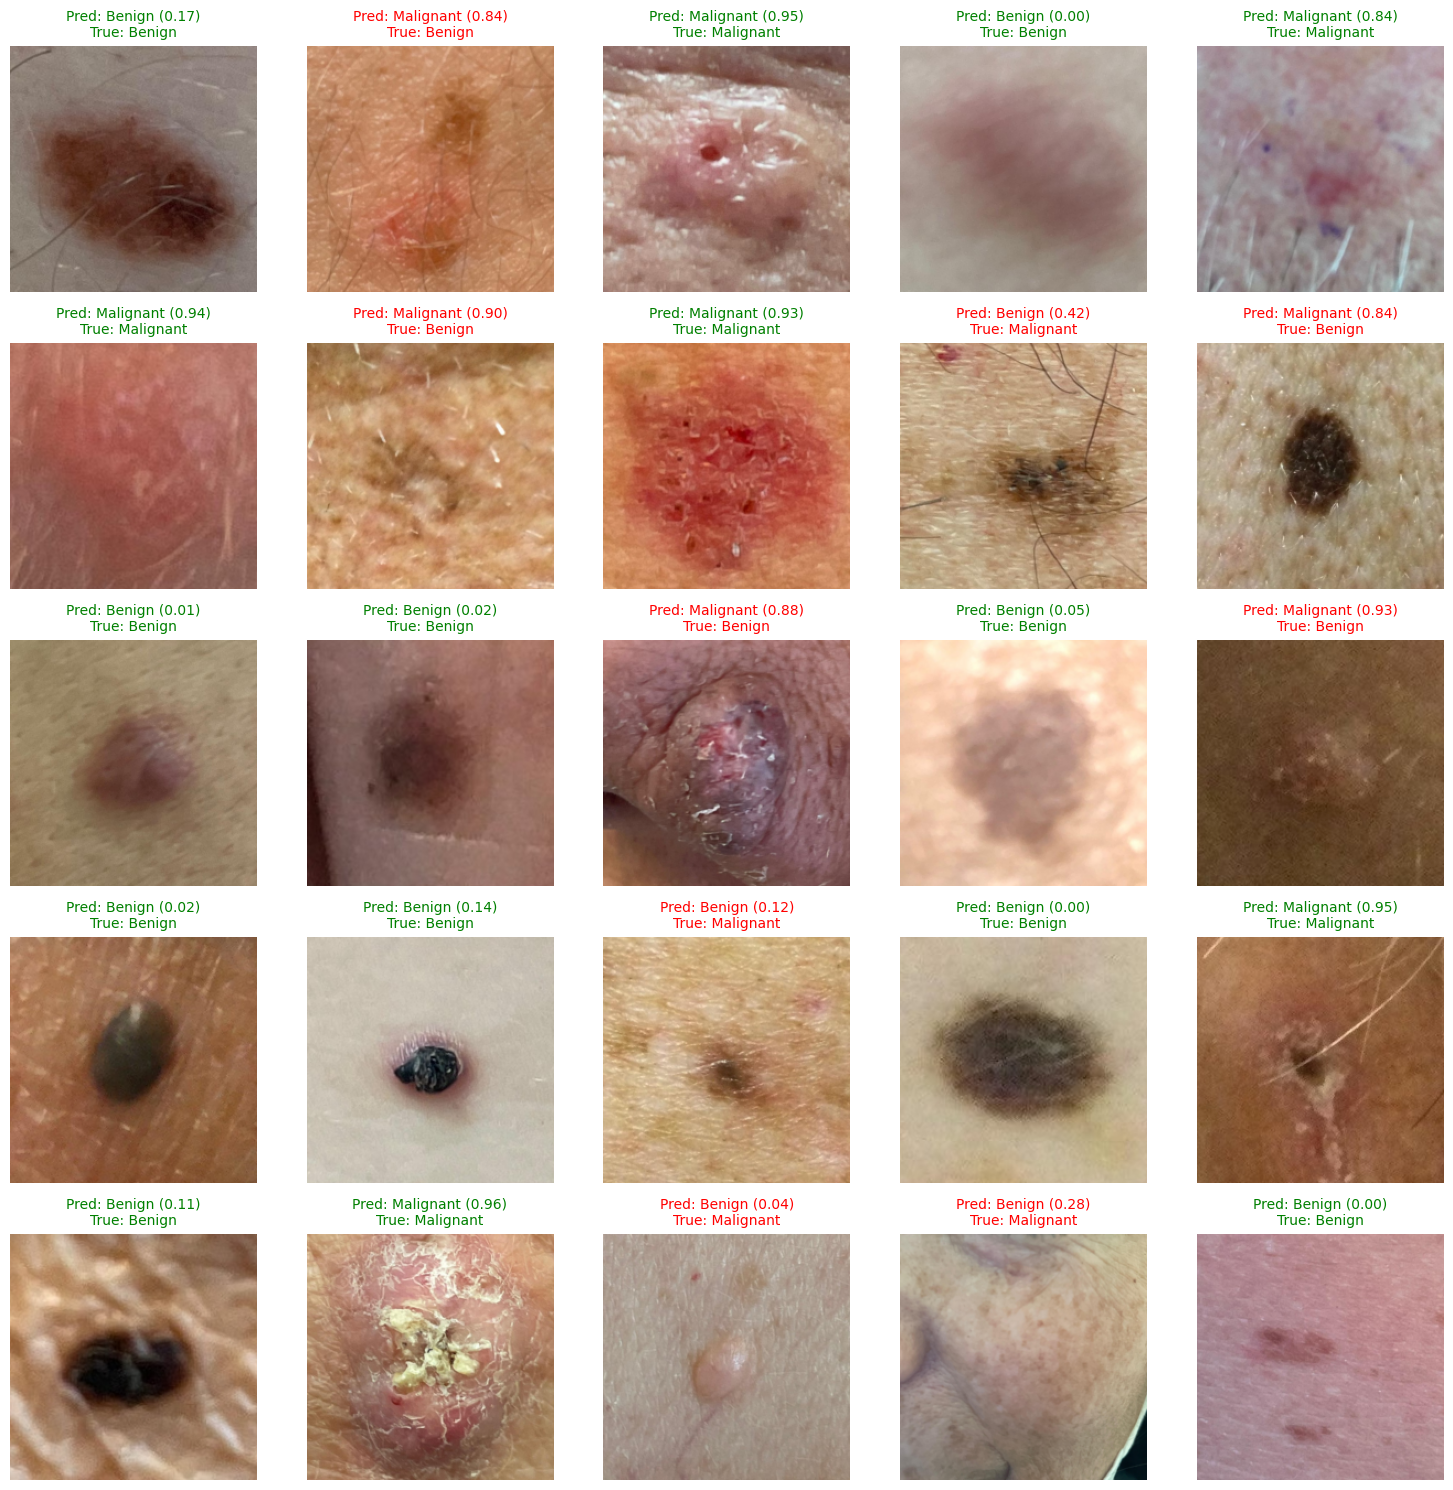

In [18]:
results = evaluate_with_preds(best_model, test_loader_midas)
show_predictions(results)


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(preds, labels, class_names=("Benign", "Malignant")):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()


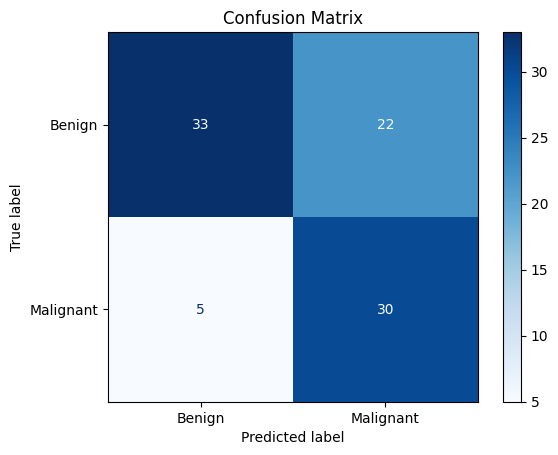

In [20]:
plot_confusion_matrix(results["preds"], results["labels"])

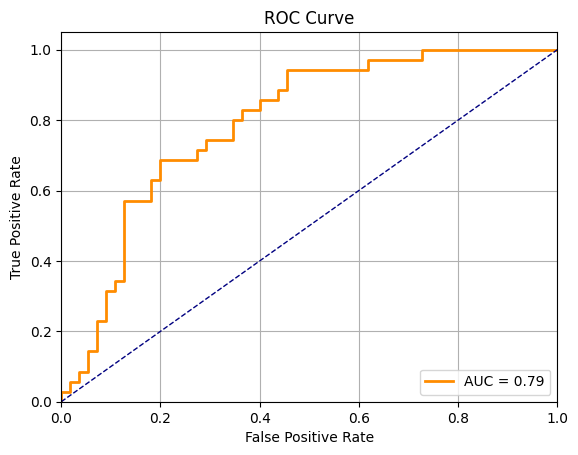

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_auc_curve(probs, labels):
    fpr, tpr, thresholds = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_auc_curve(results["probs"], results["labels"])


In [35]:
image_directories_midas = ["/home/ubuntu/cropped_midas"]
metadata_csv_midas = "midas.csv"

df = generate_kfold_csv(image_directories_midas, metadata_csv_midas)

Saved K-Fold split CSV to kfold_midas.csv


In [36]:
df

,midas_record_id,clinical_path,label,clinical_midas_distance,base_name,fold
0,780,/home/ubuntu/cropped_midas/s-prd-792965911.jpg,0,6in,s-prd-792965911,2
1,117,/home/ubuntu/cropped_midas/s-prd-465588689.jpg,0,6in,s-prd-465588689,0
2,470,/home/ubuntu/cropped_midas/s-prd-647708242.jpg,1,6in,s-prd-647708242,4
3,378,/home/ubuntu/cropped_midas/s-prd-606643360.jpg,0,6in,s-prd-606643360,0
4,105,/home/ubuntu/cropped_midas/s-prd-462526905.jpg,0,6in,s-prd-462526905,4
...,...,...,...,...,...,...
595,41,/home/ubuntu/cropped_midas/s-prd-418876279.jpg,1,6in,s-prd-418876279,0
596,428,/home/ubuntu/cropped_midas/s-prd-635950116.jpg,1,6in,s-prd-635950116,3
597,248,/home/ubuntu/cropped_midas/s-prd-522456716.jpg,0,6in,s-prd-522456716,4
598,167,/home/ubuntu/cropped_midas/s-prd-489108911.jpg,1,6in,s-prd-489108911,0
